<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/Galformer_Stock_Price_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 3: Downloading AAPL stock data...


[*********************100%***********************]  1 of 1 completed


Downloaded 753 data points
Date range: 2022-07-25 to 2025-07-24

Step 4: Normalizing data...
Original price range: $125.02 - $259.02
Scaled range: 0.0000 - 1.0000

Step 5: Creating dataset class...

Step 6: Preparing datasets...
Total dataset size (after sequence creation): 739 samples
Training samples: 591, Testing samples: 148

Step 7: Defining Galformer model...

Step 8: Initializing model...
Using device: cuda
Model parameters: 562,753

Step 9: Setting up training...

Step 10: Training model...
Epoch 1/20, Average Loss: 0.735519
Epoch 2/20, Average Loss: 0.049754
Epoch 3/20, Average Loss: 0.017920
Epoch 4/20, Average Loss: 0.007267
Epoch 5/20, Average Loss: 0.006982
Epoch 6/20, Average Loss: 0.005777
Epoch 7/20, Average Loss: 0.006521
Epoch 8/20, Average Loss: 0.005538
Epoch 9/20, Average Loss: 0.004868
Epoch 10/20, Average Loss: 0.005299
Epoch 11/20, Average Loss: 0.005269
Epoch 12/20, Average Loss: 0.005732
Epoch 13/20, Average Loss: 0.004181
Epoch 14/20, Average Loss: 0.003980
E

/tmp/ipython-input-174093835.py:256: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])
/tmp/ipython-input-174093835.py:460: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])


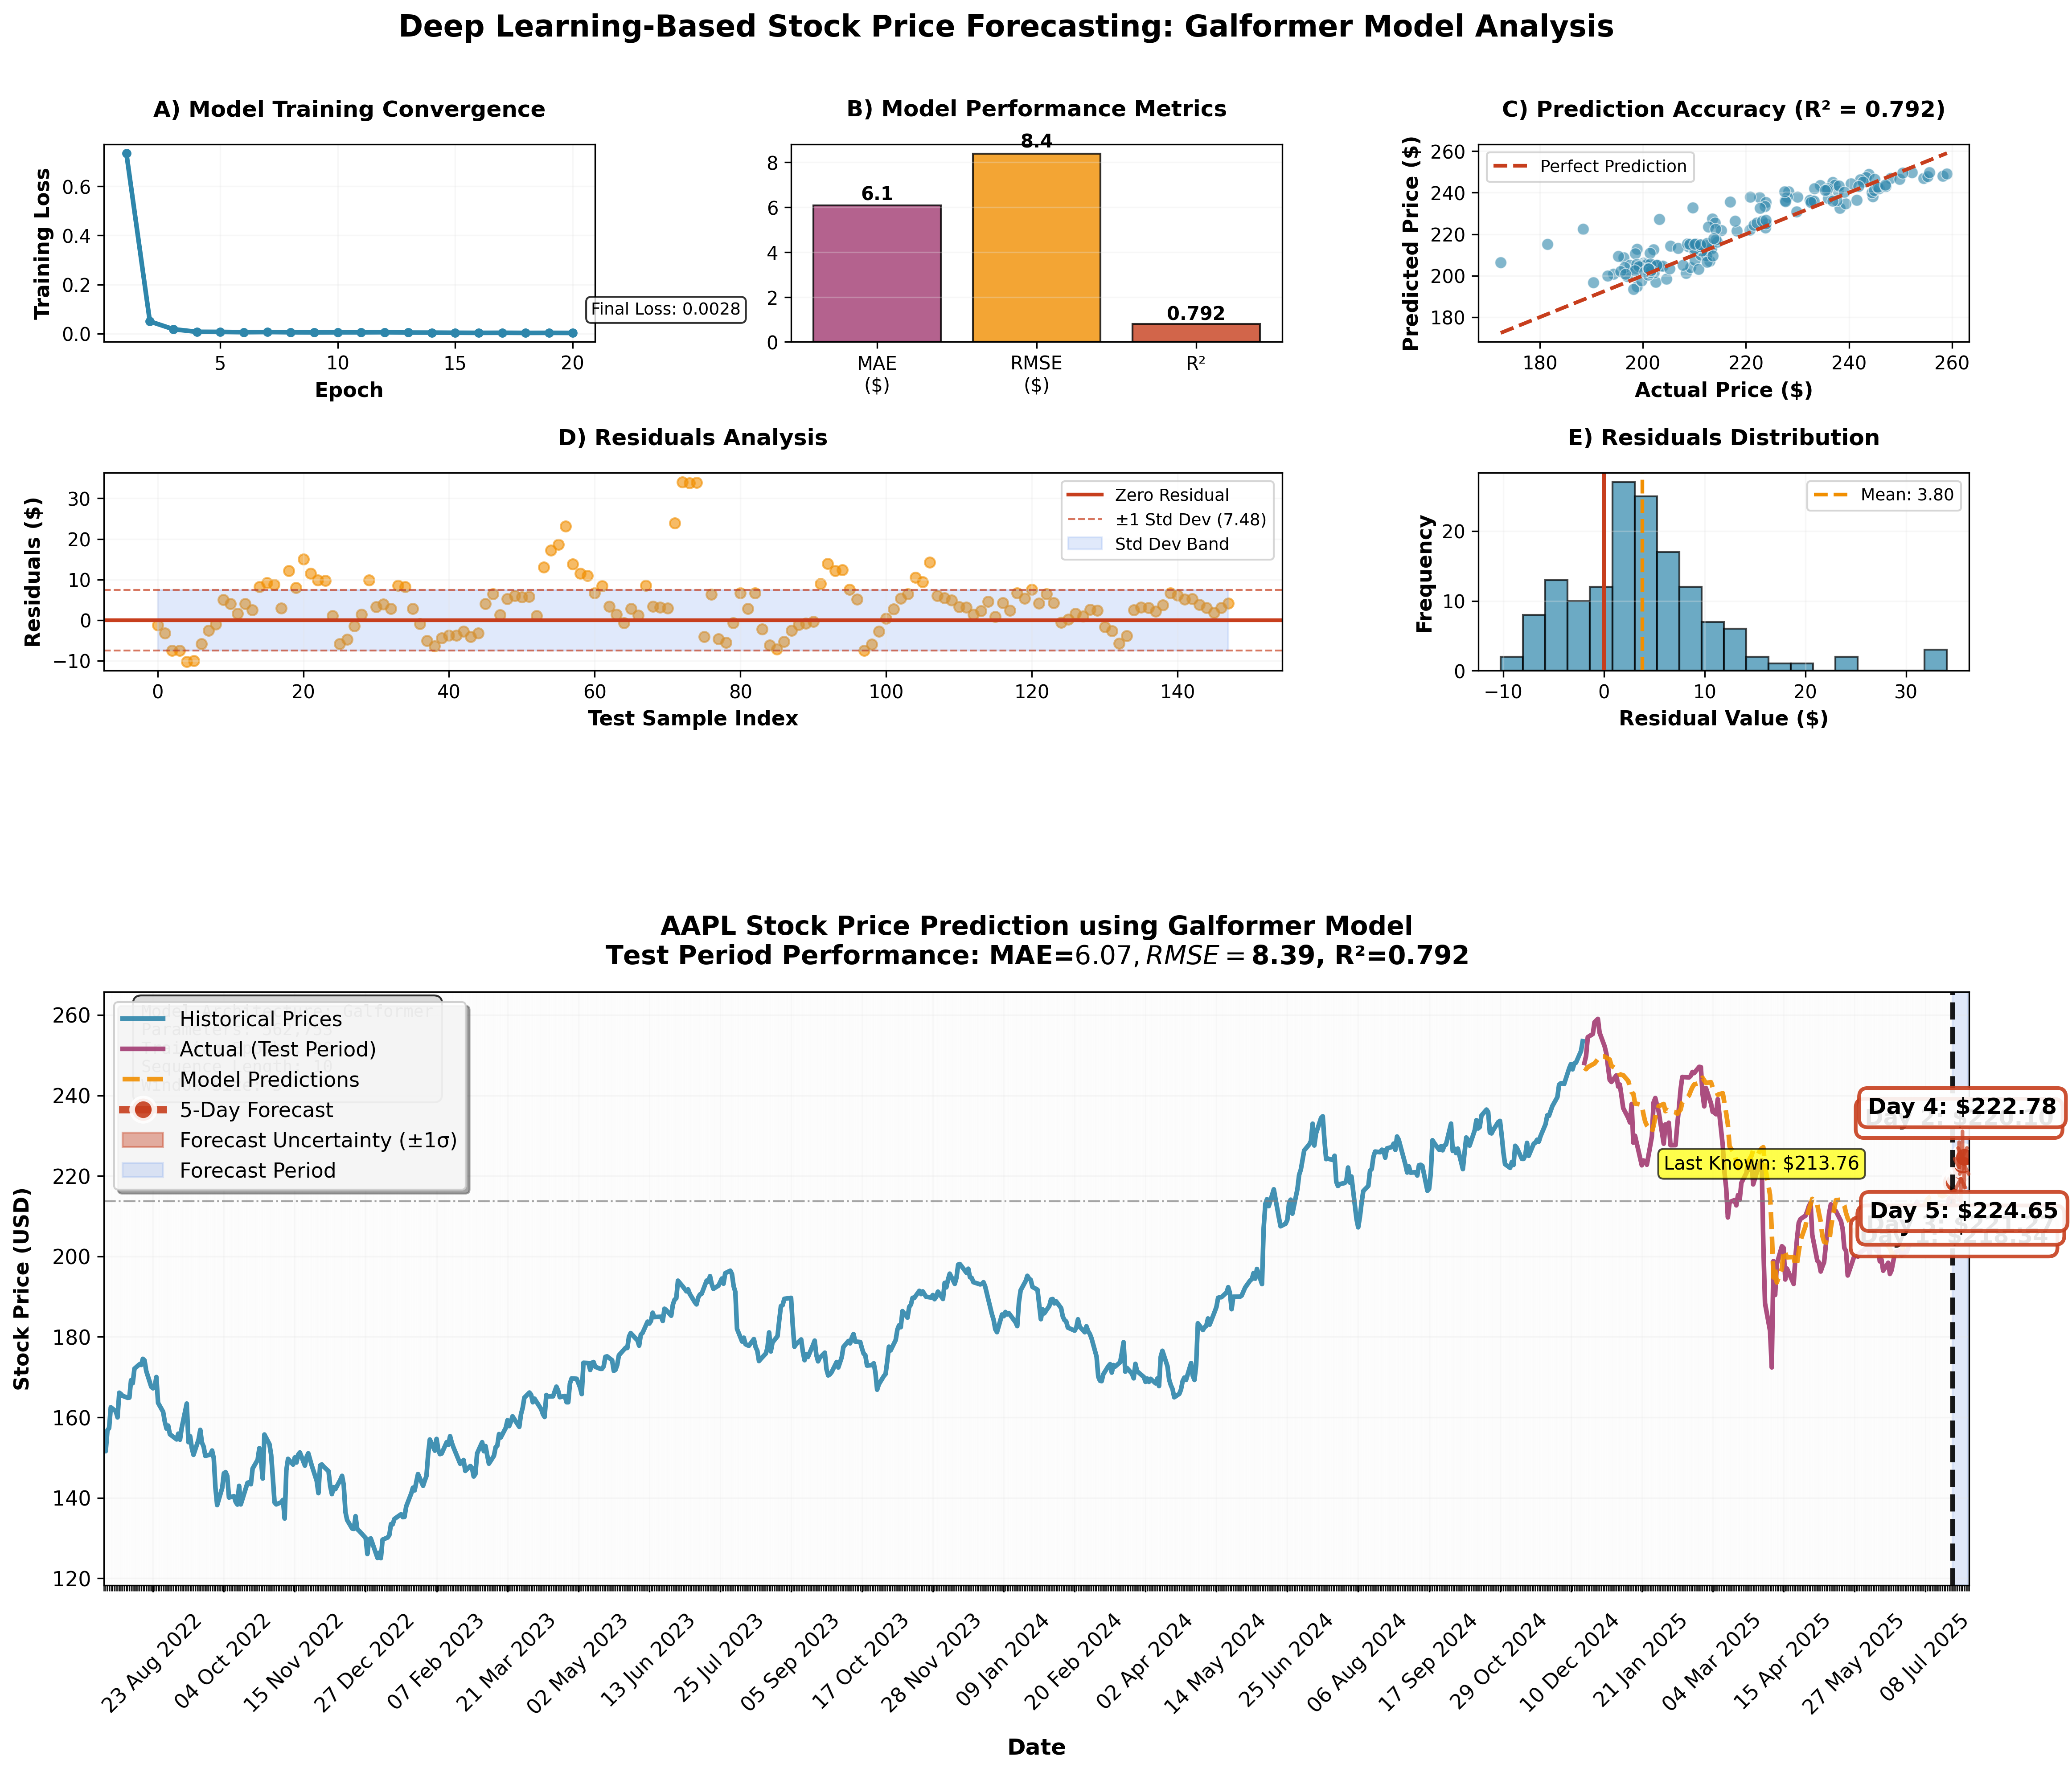

In [1]:
# 1. Install required packages
#!pip install yfinance torch scikit-learn seaborn matplotlib

# 2. Import necessary libraries
import yfinance as yf             # For downloading stock data from Yahoo Finance
import numpy as np                # For numerical operations
import pandas as pd               # For data manipulation and analysis
import matplotlib.pyplot as plt   # For plotting graphs
import matplotlib.dates as mdates # For date formatting on plots
from matplotlib.patches import Rectangle # For adding shapes to plots (not directly used in final code, but good to keep)
import seaborn as sns             # For enhanced visualizations
from sklearn.preprocessing import MinMaxScaler  # For normalizing data to 0-1 range
import torch                      # PyTorch for deep learning
import torch.nn as nn             # Neural network modules
from torch.utils.data import Dataset, DataLoader, Subset  # For creating datasets, data loaders, and chronological subsets
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Evaluation metrics

# 3. Download Apple stock data
print("Step 3: Downloading AAPL stock data...")
# Download historical stock data for Apple (AAPL)
# start: inclusive start date
# end: exclusive end date (data up to the day before this date)
# auto_adjust=False: keeps original Open, High, Low, Close, Adj Close, Volume
data = yf.download("AAPL", start="2022-07-25", end="2025-07-25", auto_adjust=False)
# Extract only the 'Close' price column and remove any missing values (e.g., for non-trading days)
data = data[['Close']].dropna()
print(f"Downloaded {len(data)} data points")
print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")

# 4. Normalize the data to range [0,1] for better neural network training
print("\nStep 4: Normalizing data...")
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
print(f"Original price range: ${data.min().values[0]:.2f} - ${data.max().values[0]:.2f}")
print(f"Scaled range: {data_scaled.min():.4f} - {data_scaled.max():.4f}")

# 5. Define custom dataset class for time series data
print("\nStep 5: Creating dataset class...")
class StockDataset(Dataset):
    def __init__(self, data, seq_len, window_size):
        """
        Initializes the StockDataset.
        Args:
            data (np.ndarray): Normalized stock prices (should be a 2D array: (num_samples, 1)).
            seq_len (int): The number of sequences (time steps) to look back for input.
            window_size (int): The size of each window within a sequence (e.g., 5 days data points per window).
        """
        self.data = data
        self.seq_len = seq_len
        self.window_size = window_size

    def __len__(self):
        """
        Returns the total number of valid samples that can be created from the data.
        A valid sample requires enough data for 'seq_len' windows and one target point.
        """
        return len(self.data) - self.seq_len - self.window_size + 1

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        Args:
            idx (int): The index of the sample to retrieve.
        Returns:
            tuple: A tuple containing (input_sequence, target_price).
                   input_sequence (torch.Tensor): Shape (seq_len, window_size, feature_dim).
                   target_price (torch.Tensor): Shape (1,).
        """
        # Create a sequence of 'seq_len' windows for the input (X)
        seq = []
        for i in range(self.seq_len):
            # Each window consists of 'window_size' data points
            window = self.data[idx + i : idx + i + self.window_size]
            seq.append(window)
        # Convert the list of windows to a NumPy array
        X = np.array(seq)  # Shape: (seq_len, window_size, feature_dim)

        # The target (y) is the price immediately following the end of the last window in the sequence
        y = self.data[idx + self.seq_len + self.window_size - 1]

        # Convert to PyTorch tensors with float32 data type
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 6. Prepare training and testing datasets
print("\nStep 6: Preparing datasets...")
seq_len = 10      # Look back 10 sequences (each sequence is a collection of windows)
window_size = 5   # Each sequence contains 5 days of data per "window"
feature_dim = 1   # Only using close price (1 feature)

# Create the full dataset of sequences and targets from the scaled data
full_dataset = StockDataset(data_scaled, seq_len, window_size)
print(f"Total dataset size (after sequence creation): {len(full_dataset)} samples")

# Split into 80% training, 20% testing chronologically
train_split_point = int(0.8 * len(full_dataset))
train_dataset = Subset(full_dataset, range(train_split_point))
test_dataset = Subset(full_dataset, range(train_split_point, len(full_dataset)))

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")

# 7. Define the Galformer model architecture
print("\nStep 7: Defining Galformer model...")
class Galformer(nn.Module):
    def __init__(self, window_size, feature_dim, embed_dim, num_heads, num_layers):
        super(Galformer, self).__init__()
        # Encoder: A linear layer to project the flattened input window into the embedding dimension
        self.encoder = nn.Linear(window_size * feature_dim, embed_dim)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Decoder: A linear layer to convert the final transformer output to the price prediction
        self.decoder = nn.Linear(embed_dim, 1)

    def forward(self, x):
        batch_size, seq_len, window_size, feature_dim = x.size()
        x = x.view(batch_size, seq_len, window_size * feature_dim)
        x = self.encoder(x)
        x = self.transformer_encoder(x)
        out = self.decoder(x[:, -1, :])
        return out

# 8. Initialize model and move to appropriate device (GPU or CPU)
print("\nStep 8: Initializing model...")
model = Galformer(
    window_size=window_size,
    feature_dim=feature_dim,
    embed_dim=64,    # Embedding dimension for each window
    num_heads=4,     # Number of attention heads in the transformer
    num_layers=2     # Number of stacked transformer encoder layers
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# 9. Set up training components
print("\nStep 9: Setting up training...")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 10. Train the model
print("\nStep 10: Training model...")
epochs = 20
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    batch_count = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        y = y.view(-1, 1)

        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

    avg_loss = total_loss / batch_count
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

# 11. Evaluate model on test set
print("\nStep 11: Evaluating model...")
model.eval()
preds, actuals = [], []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        output = model(X).cpu().numpy()
        preds.extend(output.flatten())
        actuals.extend(y.numpy().flatten())

# 12. Convert predictions back to original price scale
print("\nStep 12: Converting predictions to original scale...")
preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(actuals, preds)
mse = mean_squared_error(actuals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, preds)

print(f"Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# 13. Generate 5-day forecast
print("\nStep 13: Generating 5-day forecast...")
model.eval()
forecast_input = data_scaled[-(seq_len + window_size - 1):].copy()
forecast_prices = []

with torch.no_grad():
    for day in range(5):
        print(f"Forecasting day {day + 1}...")

        seq = []
        for i in range(seq_len):
            window = forecast_input[i:i + window_size]
            seq.append(window)

        X = torch.tensor(np.array(seq), dtype=torch.float32).unsqueeze(0).to(device)
        pred_normalized = model(X).cpu().numpy()[0, 0]
        pred_price = scaler.inverse_transform([[pred_normalized]])[0, 0]
        forecast_prices.append(pred_price)
        forecast_input = np.append(forecast_input[1:], [[pred_normalized]], axis=0)

        print(f"Day {day + 1} forecast: ${pred_price:.2f}")

print(f"\n5-Day Forecast Summary: {[f'${p:.2f}' for p in forecast_prices]}")

# Generate forecast dates starting from the day after the last known data point
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=5, freq='B')

# 14. Create Publication-Quality Figure
print("\nStep 14: Creating publication-quality visualization...")

# Set plotting style and color palette
plt.style.use('default')
sns.set_palette("husl")

# Create figure with larger width and high DPI
fig = plt.figure(figsize=(18, 14), dpi=300)  # Increased width from 16 to 18

# Define color scheme
colors = {
    'historical': '#2E86AB',
    'actual_test': '#A23B72',
    'predicted_test': '#F18F01',
    'forecast': '#C73E1D',
    'forecast_area': '#6495ED',
    'grid': '#E5E5E5'
}

# Get the last known actual price
current_price = float(data['Close'].iloc[-1])
current_price_date = data.index[-1]

# Prepare data for plotting
first_test_actual_original_idx = train_split_point + seq_len + window_size - 1
historical_data_for_plot = data.iloc[:first_test_actual_original_idx]
historical_dates_for_plot = historical_data_for_plot.index
test_dates = data.index[first_test_actual_original_idx : first_test_actual_original_idx + len(actuals)]

min_length = min(len(test_dates), len(actuals), len(preds))
test_dates_aligned = test_dates[:min_length]
actuals_aligned = actuals[:min_length]
preds_aligned = preds[:min_length]

# Create subplots with adjusted layout
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 0.3, 3],  # Increased main plot height ratio
                     width_ratios=[1, 1, 1],
                     hspace=0.5, wspace=0.4)

# Subplot A: Training Loss Evolution
ax1 = fig.add_subplot(gs[0, 0])
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, linewidth=2.5, color=colors['historical'], marker='o', markersize=4)
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Training Loss', fontsize=11, fontweight='bold')
ax1.set_title('A) Model Training Convergence', fontsize=12, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, color=colors['grid'])
ax1.tick_params(labelsize=10)
ax1.annotate(f'Final Loss: {train_losses[-1]:.4f}',
             xy=(len(train_losses), train_losses[-1]),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
             fontsize=9)

# Subplot B: Model Performance Metrics
ax2 = fig.add_subplot(gs[0, 1])
metrics = ['MAE\n($)', 'RMSE\n($)', 'R²']
values = [mae, rmse, r2]
colors_metrics = [colors['actual_test'], colors['predicted_test'], colors['forecast']]

bars = ax2.bar(metrics, values, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('B) Model Performance Metrics', fontsize=12, fontweight='bold', pad=15)
ax2.tick_params(labelsize=10)
ax2.grid(True, alpha=0.3, color=colors['grid'], axis='y')

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{value:.3f}' if value < 1 else f'{value:.1f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Subplot C: Prediction Accuracy Scatter Plot
ax3 = fig.add_subplot(gs[0, 2])
scatter = ax3.scatter(actuals, preds, alpha=0.6, s=40, c=colors['historical'],
                      edgecolors='white', linewidth=0.5)
min_val, max_val = min(actuals.min(), preds.min()), max(actuals.max(), preds.max())
ax3.plot([min_val, max_val], [min_val, max_val], '--', color=colors['forecast'],
         linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Price ($)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Predicted Price ($)', fontsize=11, fontweight='bold')
ax3.set_title(f'C) Prediction Accuracy (R² = {r2:.3f})', fontsize=12, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, color=colors['grid'])
ax3.legend(fontsize=9)
ax3.tick_params(labelsize=10)

# Subplot D: Residuals Analysis
ax4 = fig.add_subplot(gs[1, :2])
residuals = preds - actuals
ax4.scatter(range(len(residuals)), residuals, alpha=0.6, s=30, c=colors['predicted_test'])
ax4.axhline(y=0, color=colors['forecast'], linestyle='-', linewidth=2, label='Zero Residual')
std_res = np.std(residuals)
ax4.axhline(y=std_res, color=colors['forecast'], linestyle='--', alpha=0.7, linewidth=1, label=f'±1 Std Dev ({std_res:.2f})')
ax4.axhline(y=-std_res, color=colors['forecast'], linestyle='--', alpha=0.7, linewidth=1)
ax4.fill_between(range(len(residuals)), -std_res, std_res,
                 alpha=0.2, color=colors['forecast_area'], label='Std Dev Band')
ax4.set_xlabel('Test Sample Index', fontsize=11, fontweight='bold')
ax4.set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
ax4.set_title('D) Residuals Analysis', fontsize=12, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, color=colors['grid'])
ax4.tick_params(labelsize=10)
ax4.legend(fontsize=9, loc='upper right')

# Subplot E: Distribution of Residuals
ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(residuals, bins=20, alpha=0.7, color=colors['historical'], edgecolor='black', linewidth=1)
ax5.axvline(x=0, color=colors['forecast'], linestyle='-', linewidth=2)
ax5.axvline(x=np.mean(residuals), color=colors['predicted_test'], linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(residuals):.2f}')
ax5.set_xlabel('Residual Value ($)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax5.set_title('E) Residuals Distribution', fontsize=12, fontweight='bold', pad=15)
ax5.grid(True, alpha=0.3, color=colors['grid'])
ax5.legend(fontsize=9)
ax5.tick_params(labelsize=10)

# Add spacing row
fig.add_subplot(gs[2, :]).axis('off')

# Main subplot F: Time Series with Forecast
ax_main = fig.add_subplot(gs[3, :])

# Plot historical data
if len(historical_data_for_plot) > 0:
    ax_main.plot(historical_dates_for_plot, historical_data_for_plot['Close'], linewidth=2.5,
                 color=colors['historical'], label='Historical Prices', alpha=0.9)

# Plot actual and predicted prices during test period
ax_main.plot(test_dates_aligned, actuals_aligned, linewidth=2.5, color=colors['actual_test'],
             label='Actual (Test Period)', alpha=0.9)
ax_main.plot(test_dates_aligned, preds_aligned, linewidth=2.5, color=colors['predicted_test'],
             label='Model Predictions', alpha=0.9, linestyle='--')

# Enhanced forecast visualization
forecast_std = np.std(forecast_prices)
forecast_line, = ax_main.plot(forecast_dates, forecast_prices, 'o-',
                             linewidth=4, markersize=12,
                             color=colors['forecast'],
                             label='5-Day Forecast', alpha=0.9,
                             markerfacecolor=colors['forecast'],
                             markeredgecolor='white',
                             markeredgewidth=3)

# Enhanced forecast confidence band
upper_bound = np.array(forecast_prices) + forecast_std
lower_bound = np.array(forecast_prices) - forecast_std
ax_main.fill_between(forecast_dates, lower_bound, upper_bound,
                    alpha=0.4, color=colors['forecast'],
                    label='Forecast Uncertainty (±1σ)')

# Enhanced forecast period highlighting
forecast_period_start_date = data.index[-1]
forecast_period_end_date = forecast_dates[-1] + pd.Timedelta(days=2)
ax_main.axvspan(forecast_period_start_date, forecast_period_end_date,
               alpha=0.2, color=colors['forecast_area'],
               label='Forecast Period')

# Enhanced separator line
ax_main.axvline(x=forecast_period_start_date,
               color='black', linestyle='--',
               linewidth=2.5, alpha=0.9)

# Format x-axis with padding
ax_main.set_xlim([data.index[0], forecast_dates[-1] + pd.Timedelta(days=3)])

# Formatting for the main time series plot
ax_main.xaxis.set_major_locator(mdates.WeekdayLocator(interval=6))
ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
ax_main.xaxis.set_minor_locator(mdates.DayLocator())
ax_main.tick_params(axis='x', which='major', rotation=45, labelsize=11, pad=10)
ax_main.tick_params(axis='x', which='minor', length=3)
ax_main.tick_params(axis='y', labelsize=11)

ax_main.set_xlabel('Date', fontsize=12, fontweight='bold', labelpad=10)
ax_main.set_ylabel('Stock Price (USD)', fontsize=11, fontweight='bold', labelpad=10)
ax_main.set_title('AAPL Stock Price Prediction using Galformer Model\n' +
                 f'Test Period Performance: MAE=${mae:.2f}, RMSE=${rmse:.2f}, R²={r2:.3f}',
                 fontsize=14, fontweight='bold', pad=15)

ax_main.grid(True, which='major', alpha=0.3, color=colors['grid'])
ax_main.grid(True, which='minor', alpha=0.1, color=colors['grid'])

# Enhanced legend
legend = ax_main.legend(loc='upper left', fontsize=11, frameon=True,
                        fancybox=True, shadow=True, framealpha=0.9)
legend.get_frame().set_facecolor('white')

# Enhanced forecast value annotations
for i, (date, price) in enumerate(zip(forecast_dates, forecast_prices)):
    ax_main.annotate(f'Day {i+1}: ${price:.2f}',
                    xy=(date, price),
                    xytext=(0, 25 if i%2 else -35),
                    textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.4',
                             facecolor='white',
                             edgecolor=colors['forecast'],
                             alpha=0.9, linewidth=2),
                    fontsize=12, fontweight='bold',
                    ha='center', va='bottom',
                    arrowprops=dict(arrowstyle='->',
                                  color=colors['forecast'],
                                  linewidth=2,
                                  alpha=0.7))

# Model information box
info_text = f"""Model Architecture: Galformer
Parameters: {sum(p.numel() for p in model.parameters()):,}
Training Epochs: {epochs}
Sequence Length: {seq_len}
Window Size: {window_size}"""

ax_main.text(0.02, 0.98, info_text, transform=ax_main.transAxes,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8),
             fontsize=9, verticalalignment='top', fontfamily='monospace')

# Current price indicator
ax_main.axhline(y=current_price, color='gray', linestyle='-.', alpha=0.7, linewidth=1)
ax_main.annotate(f'Last Known: ${current_price:.2f}',
                 xy=(current_price_date, current_price),
                 xytext=(-50, 15),
                 textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                 fontsize=10, va='bottom', ha='right')

# Final layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
fig.suptitle('Deep Learning-Based Stock Price Forecasting: Galformer Model Analysis',
             fontsize=16, fontweight='bold', y=0.95)

# Save figures
plt.savefig('galformer_stock_prediction_analysis.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('galformer_stock_prediction_analysis.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()